# Import Packages

In [108]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Load Data

In [109]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()

# Setup Model

In [110]:
print(df.columns)

Index(['policy_nr_hashed', 'welcome_discount', 'last_data_year',
       'years_to_churn', 'control_group', 'first_premium', 'first_split',
       'first_customer_age', 'first_accident_free_years', 'first_car_value',
       'first_age_car', 'first_brand', 'first_type', 'first_weight',
       'first_fuel_type', 'first_postcode', 'first_product',
       'first_allrisk basis', 'first_allrisk compleet', 'first_allrisk royaal',
       'first_wa-extra', 'first_wettelijke aansprakelijkheid', 'nr_cars',
       'fake_alarm', 'policyholder_change', 'max_nr_coverages',
       'accident_years', 'last_year_car_change', 'years_since_last_car_change',
       'lpa'],
      dtype='object')


In [140]:
display(df.groupby("years_to_churn").count())

,policy_nr_hashed,welcome_discount,last_data_year,control_group,first_premium,first_split,first_customer_age,first_accident_free_years,first_car_value,first_age_car,...,first_wa-extra,first_wettelijke aansprakelijkheid,nr_cars,fake_alarm,policyholder_change,max_nr_coverages,accident_years,last_year_car_change,years_since_last_car_change,lpa
years_to_churn,,,,,,,,,,,,,,,,,,,,,
0,57488,57488,57488,57488,57488,57486,57488,57488,57488,57488,...,57488,57488,57488,57488,57488,57488,57488,57488,3113,57488
1,3591,3591,3591,3591,3591,3591,3591,3591,3591,3591,...,3591,3591,3591,3591,3591,3591,3591,3591,197,3591
2,567,567,567,567,567,567,567,567,567,567,...,567,567,567,567,567,567,567,567,70,567
3,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,5,10


In [133]:
df["first_product"] = df["first_product"].astype("category")
df["first_brand"] = df["first_brand"].astype("category")

X = df[['welcome_discount','first_split','nr_cars', "first_premium", "first_age_car", "first_car_value", "first_weight", "first_product", "first_brand"]]
y = df['years_to_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
lgtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=["first_product", "first_brand"])

# Model Selection

In [135]:
clf = lgb.LGBMClassifier(
    objective='multiclass',
    force_row_wise=True,
    num_leaves=100,
    verbosity=-1,
)

scores_f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
# scores_roc_auc = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

print('CV Average F1 score: {0:0.4f}'.format(np.mean(scores_f1)))
# print('CV Average ROC/AUC score: {0:0.4f}'.format(np.mean(scores_roc_auc)))

CV Average F1 score: 0.2702


# Validation

In [138]:
clf.fit(X_train, y_train)

print(clf.predict_proba(X_test))

[[1.00000000e+000 2.98438405e-167 1.60893775e-168 0.00000000e+000]
 [9.88987528e-001 1.09722046e-002 4.02675499e-005 0.00000000e+000]
 [9.85985268e-001 1.39874834e-002 2.72483642e-005 1.68723982e-216]
 ...
 [9.93585561e-001 5.46984991e-003 9.44589220e-004 0.00000000e+000]
 [9.70649989e-001 2.60173698e-002 3.33264145e-003 0.00000000e+000]
 [9.99974925e-001 2.28643713e-005 2.21089492e-006 0.00000000e+000]]


LightGBM Model F1 score: 0.2763


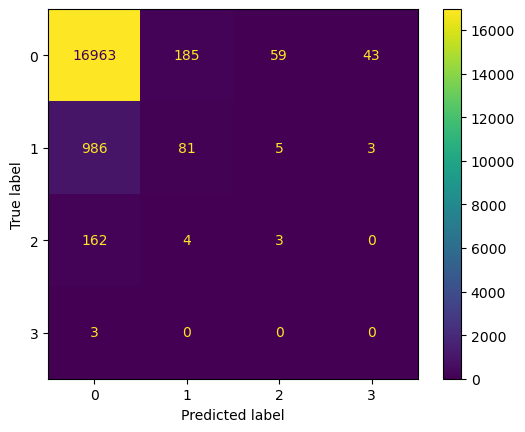

In [139]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('LightGBM Model F1 score: {0:0.4f}'.format(f1_score(y_test, y_pred, average="macro")))
# print('LightGBM Model ROC/AUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()